In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from single_cond_utils import PA_with_LEDON_2_VEC
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn
from psiam_tied_dv_map_utils_with_PDFs import down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_fn
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn

import io
import matplotlib.gridspec as gridspec
import corner

from single_cond_utils import PA_with_LEDON_2_VEC
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn
from types import SimpleNamespace
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_time_varying_led_off_fn

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


In [3]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# remove ILD 16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]
# TEMP: remove ILD 8 also
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([8, -8]) ]
print(f'len of ILD 16, 8 removed: {len(df_led_off)}')

# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of ILD 16, 8 removed: 39722
len of led off valid trials = 31945
len of valid trials < 1s : 31308


In [4]:
conditions = {'ABL': [20], 'ILD': [2]}

In [5]:
# Applying the filter
df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
    (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
    (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
]

In [6]:
print(f'lenm of conditioned trials = {len(df_led_off_valid_trials_cond_filtered)}')
ABLs_cond = df_led_off_valid_trials_cond_filtered['ABL'].unique()
ILDs_cond = df_led_off_valid_trials_cond_filtered['ILD'].unique()
print(ABLs_cond)
print(ILDs_cond)

lenm of conditioned trials = 1708
[20]
[2.]


In [7]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 

# other params
# Z_E = 0
K_max = 10

# LED Off - no noise
noise = 0

# phi params 
bump_offset = 0

In [8]:
# bump_width = 0.23   # h1
# bump_height = 0.25  # a1
# dip_width = 0.05    # h2
# dip_height = 0.5    # a2

# loglike fn

In [9]:
def compute_loglike_trial(row, gamma, omega, t_E_aff, w, bump_width, bump_height, dip_width, dip_height):
    phi_params =  {
    'h1': bump_width,
    'a1': bump_height,
    'b1': bump_offset,
    'h2': dip_width,
    'a2': dip_height
    }
    phi_params_obj = SimpleNamespace(**phi_params)

    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    response_poke = row['response_poke']
    

    t_pts = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts)
    trunc_factor_p_joint = area_btn_stim_and_1s
    
    bound_val = 2*response_poke - 5
    P_joint_rt_choice = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_time_varying_led_off_fn(rt, V_A, theta_A, gamma, omega, t_stim, \
                                            t_A_aff, t_E_aff, del_go, phi_params_obj, w, bound_val, K_max)
    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)


    return wt_log_like


def vbmc_loglike_fn(params):
    gamma, omega, t_E_aff, w, bump_width, bump_height, dip_width, dip_height = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff, w, \
                                                                     bump_width, bump_height, dip_width, dip_height) \
                                     for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
    
    return np.sum(all_loglike)

# bounds

In [10]:
gamma_bounds = [0.02, 2]
gamma_plausible_bounds = [0.09, 0.9]

omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

w_bounds = [0.01, 0.99]
w_plausible_bounds = [0.3, 0.7]

bump_width_bounds = [0.01, 1]
bump_width_plausible_bounds = [0.1, 0.4]

bump_height_bounds = [0.01, 1]
bump_height_plausible_bounds = [0.1, 0.5]

dip_width_bounds = [0.005, 0.5]
dip_width_plausible_bounds = [0.01, 0.1]

dip_height_bounds = [0.01, 1]
dip_height_plausible_bounds = [0.3, 0.7]

# prior

In [11]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff, w, bump_width, bump_height, dip_width, dip_height = params

    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    w_logpdf = trapezoidal_logpdf(w, w_bounds[0], w_plausible_bounds[0], w_plausible_bounds[1], w_bounds[1])

    bump_width_logpdf = trapezoidal_logpdf(bump_width, bump_width_bounds[0], bump_width_plausible_bounds[0], bump_width_plausible_bounds[1], bump_width_bounds[1])
    bump_height_logpdf = trapezoidal_logpdf(bump_height, bump_height_bounds[0], bump_height_plausible_bounds[0], bump_height_plausible_bounds[1], bump_height_bounds[1])
    dip_width_logpdf = trapezoidal_logpdf(dip_width, dip_width_bounds[0], dip_width_plausible_bounds[0], dip_width_plausible_bounds[1], dip_width_bounds[1])
    dip_height_logpdf = trapezoidal_logpdf(dip_height, dip_height_bounds[0], dip_height_plausible_bounds[0], dip_height_plausible_bounds[1], dip_height_bounds[1])

    return (
        gamma_logpdf +
        omega_logpdf +
        t_E_aff_logpdf +
        w_logpdf +
        bump_width_logpdf +
        bump_height_logpdf +
        dip_width_logpdf +
        dip_height_logpdf
    )


# prior + loglike

In [12]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [13]:
# Add bounds for all parameters
lb = np.array([
    gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0], w_bounds[0],
    bump_width_bounds[0], bump_height_bounds[0], dip_width_bounds[0], dip_height_bounds[0]
])
ub = np.array([
    gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1], w_bounds[1],
    bump_width_bounds[1], bump_height_bounds[1], dip_width_bounds[1], dip_height_bounds[1]
])

plb = np.array([
    gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0], w_plausible_bounds[0],
    bump_width_plausible_bounds[0], bump_height_plausible_bounds[0], dip_width_plausible_bounds[0], dip_height_plausible_bounds[0]
])
pub = np.array([
    gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1], w_plausible_bounds[1],
    bump_width_plausible_bounds[1], bump_height_plausible_bounds[1], dip_width_plausible_bounds[1], dip_height_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
w_0 = np.random.uniform(w_plausible_bounds[0], w_plausible_bounds[1])
bump_width_0 = np.random.uniform(bump_width_plausible_bounds[0], bump_width_plausible_bounds[1])
bump_height_0 = np.random.uniform(bump_height_plausible_bounds[0], bump_height_plausible_bounds[1])
dip_width_0 = np.random.uniform(dip_width_plausible_bounds[0], dip_width_plausible_bounds[1])
dip_height_0 = np.random.uniform(dip_height_plausible_bounds[0], dip_height_plausible_bounds[1])

x_0 = np.array([
    gamma_0, omega_0, t_E_aff_0, w_0,
    bump_width_0, bump_height_0, dip_width_0, dip_height_0
])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 8).
Reshaping upper bounds to (1, 8).
Reshaping plausible lower bounds to (1, 8).
Reshaping plausible upper bounds to (1, 8).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -425.99       244.22          inf        2        inf     start warm-up
     1         15         397.23       133.96     12992.41        2        inf     
     2         20         521.77        49.20       354.45        2   4.76e+03     
     3         25         563.01        55.50      1150.72        2   1.39e+04     
     4         30         588.77        11.99       620.95        2   7.44e+03     
     5         35         634.46        17.85        91.68        2   1.29e+03     
     6         40         628.83         6.90        17.27        2        245     
     7         45         632.35         4.9

In [ ]:
# vbmc.save(f'test_with_time_varying_fit.pkl')

In [ ]:
# with open(f"test_with_time_varying_fit.pkl", 'rb') as f:
#     vp = pickle.load(f)

# vp = vp.vp

# sample

In [16]:
# Sample from the VBMC posterior
vp_samples = vp.sample(int(1e5))[0]

# Extract samples for each parameter
gamma_samples = vp_samples[:, 0]
omega_samples = vp_samples[:, 1]
t_E_aff_samples = vp_samples[:, 2]
w_samples = vp_samples[:, 3]
bump_width_samples = vp_samples[:, 4]
bump_height_samples = vp_samples[:, 5]
dip_width_samples = vp_samples[:, 6]
dip_height_samples = vp_samples[:, 7]

# Compute mean estimates
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()
w = w_samples.mean()
bump_width = bump_width_samples.mean()
bump_height = bump_height_samples.mean()
dip_width = dip_width_samples.mean()
dip_height = dip_height_samples.mean()



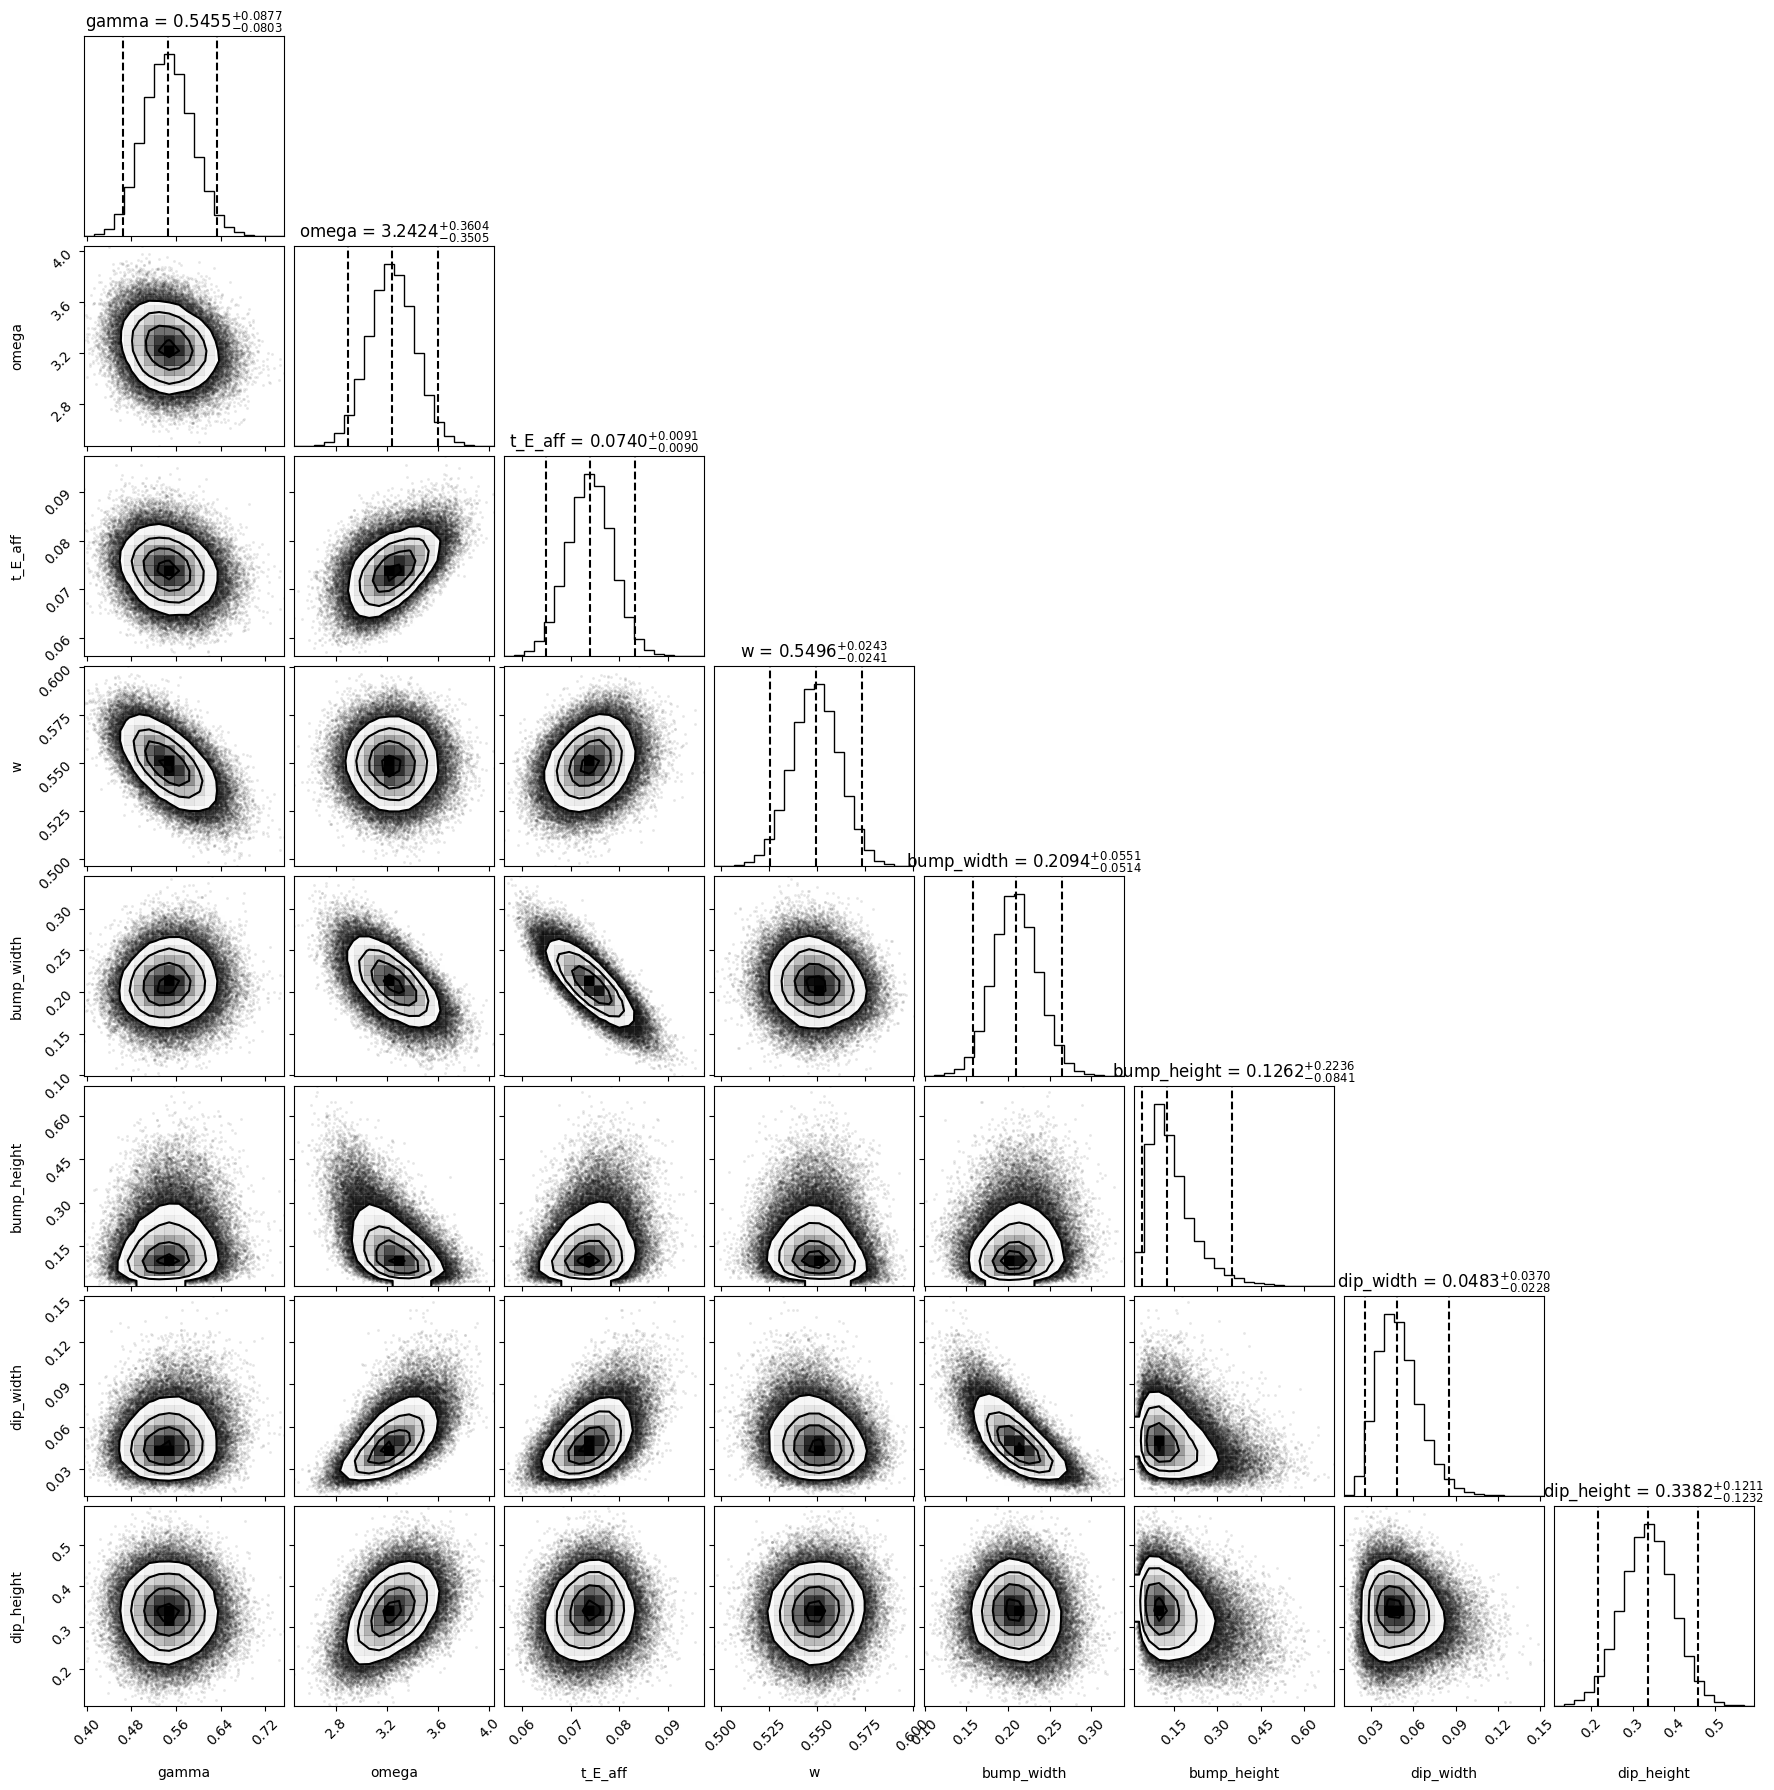

In [17]:
# Create array for corner plot
corner_samples = np.vstack([
    gamma_samples, omega_samples, t_E_aff_samples, w_samples,
    bump_width_samples, bump_height_samples, dip_width_samples, dip_height_samples
]).T

# Compute ranges for plot
percentiles = np.percentile(corner_samples, [0, 100], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(corner_samples.shape[1])]

# Labels for each parameter
param_labels = [
    'gamma', 'omega', 't_E_aff', 'w',
    'bump_width', 'bump_height', 'dip_width', 'dip_height'
]

# Generate corner plot
corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);

# diagnostics

In [18]:
# DATA
df_led_off = df[df['LED_trial'] == 0]

# < 1s RTs
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
# remove truncated aborts
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
# renaming
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

### ABORTS + VALID TRIALS + ABL, ILD CONDITION
data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
    (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
]

data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

# VALID TRIALS CONDITION
df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
    (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
]

df_led_off_valid_trials_cond_filtered['ABL'].unique(), df_led_off_valid_trials_cond_filtered['ILD'].unique()

(array([20]), array([2.]))

# up and down rt

In [19]:
phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [20]:
N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A, theta_A, t_stim, t_LED, t_A_aff)
    P_A_samples[idx, :] = pdf

P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [21]:
up_wrt_stim = np.zeros_like(t_pts)
down_wrt_stim = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    
    up_wrt_stim[idx] =  up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, 1, K_max)
    down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, -1, K_max)


In [22]:
bins = np.arange(-1,1,0.02)
bin_centers = (bins[:-1] + bins[1:]) / 2



## data
data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

data_up_rt = data_up['rt'] - data_up['t_stim']
data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

data_down_rt = data_down['rt'] - data_down['t_stim']
data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

frac_up_data = len(data_up) / len(df_led_off_valid_trials_cond_filtered)
frac_down_data = len(data_down) / len(df_led_off_valid_trials_cond_filtered)

areas theory up = 0.744, down = 0.243
frac up data = 0.752, down data = 0.248


Text(0, 0.5, 'density')

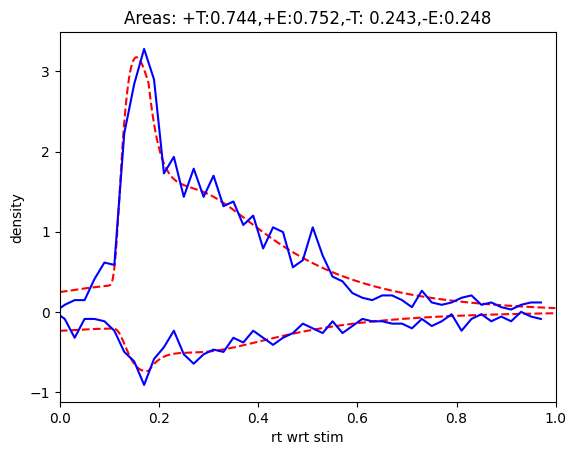

In [23]:
# RTDs - up and down
plt.plot(t_pts, up_wrt_stim, ls='--', color='r')
plt.plot(t_pts, -down_wrt_stim, ls='--', color='r')

plt.plot(bin_centers, data_up_rt_hist*frac_up_data, color='b')
plt.plot(bin_centers, -data_down_rt_hist*frac_down_data, color='b')

theory_area_up = trapz(up_wrt_stim, t_pts)
theory_area_down = trapz(down_wrt_stim, t_pts)

print(f'areas theory up = {theory_area_up :.3f}, down = {theory_area_down :.3f}')
print(f'frac up data = {frac_up_data :.3f}, down data = {frac_down_data :.3f}')
plt.xlim(0,1)
plt.title(f'Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},-T:{theory_area_down: .3f},-E:{frac_down_data :.3f}')

plt.xlabel('rt wrt stim')
plt.ylabel('density')

# accuracy

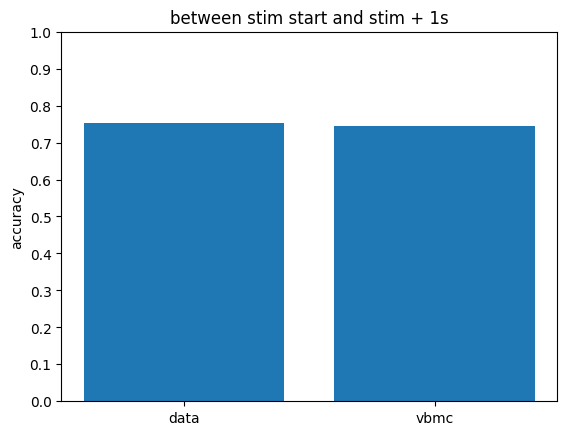

In [24]:
## 2. Accuracy
xlabels = ['data', 'vbmc']
if conditions['ILD'][0] > 0:
    accuracy_data_and_theory = [frac_up_data, theory_area_up]
else:
    accuracy_data_and_theory = [frac_down_data, theory_area_down]

plt.bar(xlabels, accuracy_data_and_theory)
plt.ylabel('accuracy')
plt.title('between stim start and stim + 1s')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1));

# tacho

In [25]:
# P_rt = np.zeros_like(t_pts)
tacho = np.zeros_like(t_pts)
# all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    
    P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, 1, K_max)
    P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_wrt_stim_time_varying_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, phi_params_obj, w, -1, K_max)
    
    if conditions['ILD'][0] > 0:
        P_rt_c = P_up
    else:
        P_rt_c = P_down
        
    P_rt = P_up + P_down
    tacho[idx] = P_rt_c / P_rt

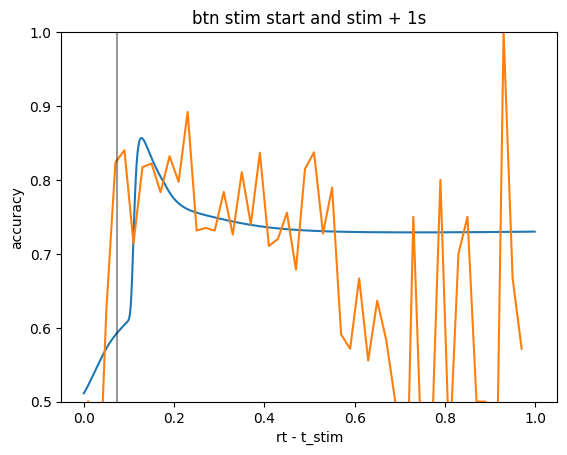

In [26]:
df_led_off_valid_trials_cond_filtered_copy = df_led_off_valid_trials_cond_filtered.copy()
df_led_off_valid_trials_cond_filtered_copy.loc[:, 'RT_bin'] = pd.cut(df_led_off_valid_trials_cond_filtered_copy['rt'] - df_led_off_valid_trials_cond_filtered_copy['t_stim'],\
                                                              bins = bins, include_lowest=True)
grouped_by_rt_bin = df_led_off_valid_trials_cond_filtered_copy.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

##  3. Tacho
plt.plot(t_pts, tacho)
plt.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')

plt.ylim(0.5,1)
plt.xlabel('rt - t_stim')
plt.ylabel('accuracy')
plt.title('btn stim start and stim + 1s')
plt.axvline(t_E_aff, alpha=0.4, color='k')